In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [50]:
file_path = './data/hack_train.csv'
data = pd.read_csv(file_path)

data['label'] = data['label'].astype('category')

n_samples = 20000

df = data.groupby('label').apply(lambda x: x.sample(n=n_samples, random_state=42)).reset_index(drop=True)

/tmp/ipykernel_98091/143836168.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = data.groupby('label').apply(lambda x: x.sample(n=n_samples, random_state=42)).reset_index(drop=True)
/tmp/ipykernel_98091/143836168.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = data.groupby('label').apply(lambda x: x.sample(n=n_samples, random_state=42)).reset_index(drop=True)


In [51]:
df.shape

(40000, 3)

In [52]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   text    40000 non-null  object  
 1   label   40000 non-null  category
 2   src     40000 non-null  object  
dtypes: category(1), object(2)
memory usage: 664.3+ KB
None


## Preprocessing

In [53]:
df = df.drop(['src'], axis=1)


exclude = set(string.punctuation)
def remove_punctuation(row):
    row.text = ''.join(ch for ch in row.text if ch not in exclude)
    return row
    
df = df.apply(remove_punctuation, axis = 1)

df['text'] = df['text'].apply(lambda x: x.lower())


In [54]:
# we will lemmatize the words
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/onyxia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [55]:
# we will also do a stemming of the words to see if it improves the model
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

## Data analysis

In [56]:
df.shape

(40000, 2)

<Axes: xlabel='label', ylabel='count'>

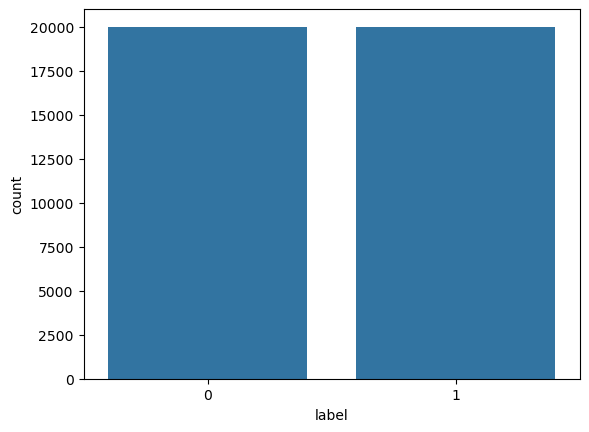

In [57]:
sns.countplot(x=df['label'])

In [58]:
description = pd.DataFrame()
description['description_length'] = df.text.apply(len)
print("Mean description length: ", description['description_length'].mean())
print("Min overview length: ", description['description_length'].min())
print("Max overview length: ", description['description_length'].max())

Mean description length:  1078.5114
Min overview length:  22
Max overview length:  56226


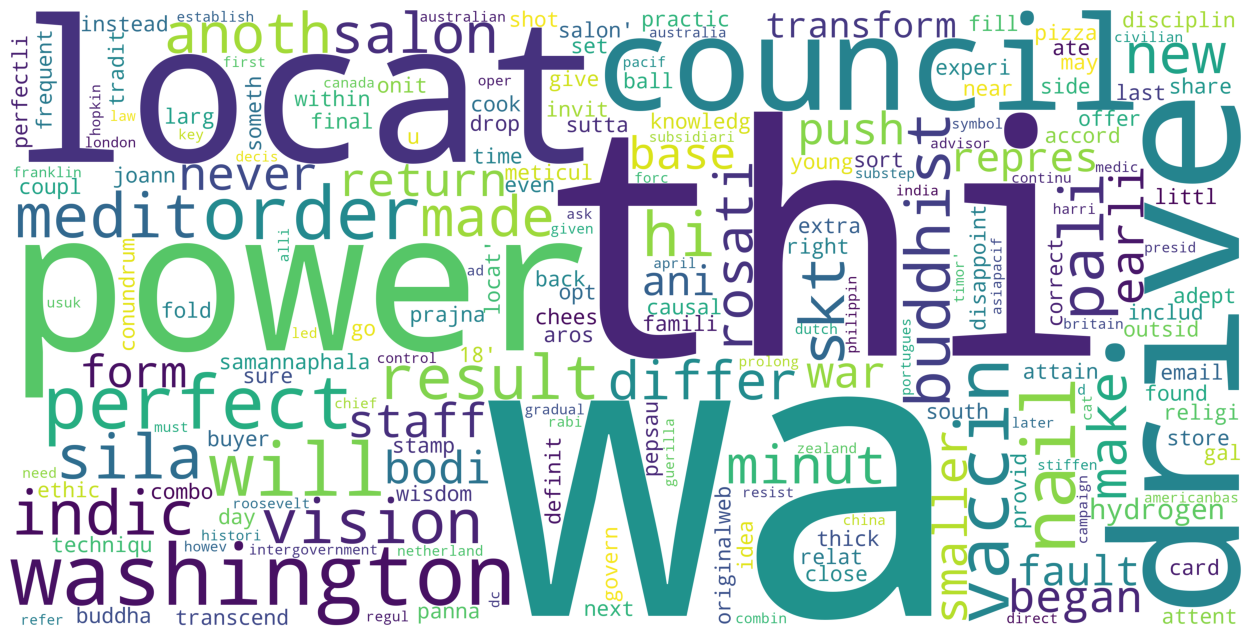

In [59]:
# word cloud sur les réponses humaines
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
human = df[df['label'] == True]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

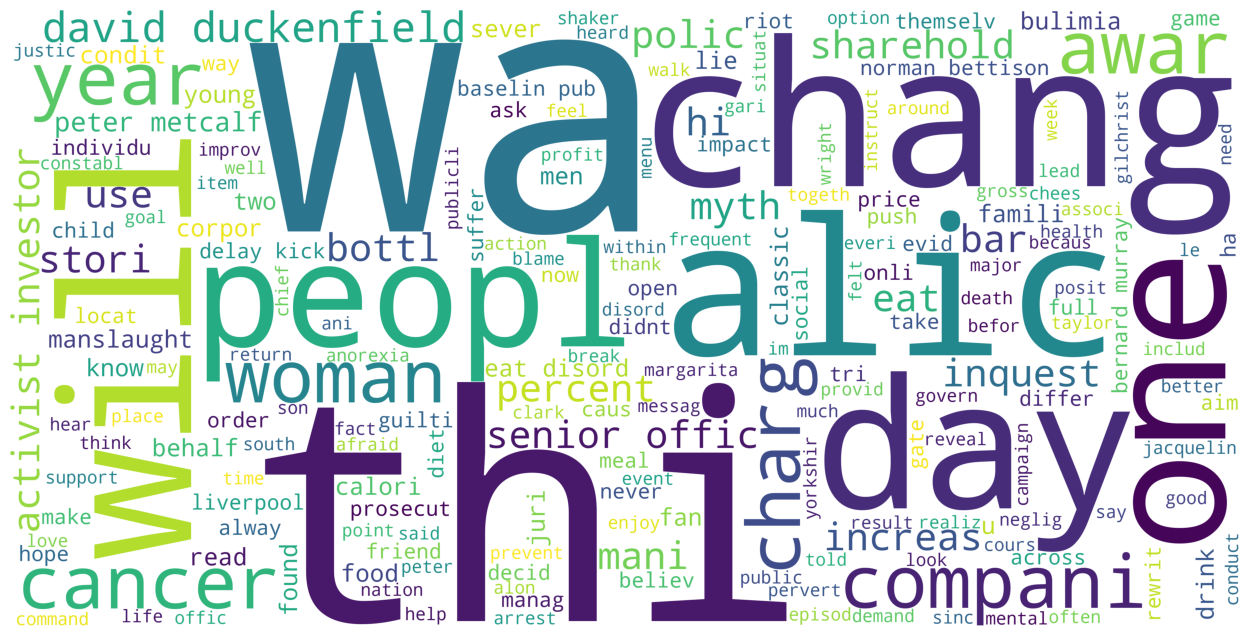

In [60]:
# word cloud sur les réponses de GPT
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
human = df[df['label'] == False]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Model selection and tunning 

In [61]:
X = df['text']  
y = df['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'model__n_estimators': [50, 100, 200]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 1.0]}
    },
    'SVM': {
        'model': SVC(),
        'params': {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}
    },
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'model__C': [0.1, 1, 10]}
    },
    'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {'model__alpha': [0.01, 0.1, 1]}
    }
}

grid_search_objects = {}
results = {}

for name, m in models.items():
    pipe = Pipeline([
        ('count_vect', CountVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))),
        ('tfidf_transformer', TfidfTransformer()),
        ('model', m['model'])
    ])
    grid_search = GridSearchCV(pipe, m['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_search_objects[name] = grid_search
    results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }

for name, res in results.items():
    print(f"{name}: Meilleure précision = {res['best_score']}")
    print(f"Meilleurs paramètres : {res['best_params']}")


Random Forest: Meilleure précision = 0.83253125
Meilleurs paramètres : {'model__n_estimators': 200}
Gradient Boosting: Meilleure précision = 0.74434375
Meilleurs paramètres : {'model__learning_rate': 1.0, 'model__n_estimators': 200}
SVM: Meilleure précision = 0.88359375
Meilleurs paramètres : {'model__C': 10, 'model__gamma': 'scale'}
Logistic Regression: Meilleure précision = 0.7769062499999999
Meilleurs paramètres : {'model__C': 10}
Naive Bayes: Meilleure précision = 0.7266874999999999
Meilleurs paramètres : {'model__alpha': 0.1}


In [63]:
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

# Évaluation des meilleurs modèles sur le test set avec des métriques supplémentaires
test_results = {}
for name, grid_search in grid_search_objects.items():
    best_model = grid_search.best_estimator_
    
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    test_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'prediction_time': prediction_time,
        'classification_report': classification_report(y_test, y_pred)
    }

    print(f"{name} Test Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Prediction Time: {prediction_time} seconds")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Random Forest Test Metrics:
Accuracy: 0.845875
Precision: 0.8463483351358796
Recall: 0.845875
F1 Score: 0.8458098760740513
Prediction Time: 2.5265696048736572 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      4014
           1       0.86      0.83      0.84      3986

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000

Gradient Boosting Test Metrics:
Accuracy: 0.760625
Precision: 0.7607271167089541
Recall: 0.760625
F1 Score: 0.7606127129413081
Prediction Time: 1.5841116905212402 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      4014
           1       0.76      0.77      0.76      3986

    accuracy                           0.76      8000
   macro avg       0.76      0.76      0.76      8000
weighted avg     